Import

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn import tree as _tree

Callable functions

In [8]:
# Define the vt_subgroups function
def vt_subgroups(tree_classifier, feature_names, X, Y, T, only_leaf=True, only_fav=True, tables=True, verbose=False, compete=False):
    """
    Extracts and displays subgroups from a decision tree classifier, including treatment and outcome statistics.

    Parameters:
    - tree_classifier: The trained DecisionTreeClassifier object.
    - feature_names: List of feature names.
    - X: Feature matrix (numpy array or pandas DataFrame).
    - Y: Target variable (numpy array or pandas Series).
    - T: Treatment variable (numpy array or pandas Series).
    - only_leaf: If True, only terminal nodes are displayed.
    - only_fav: If True, only nodes with Z^* = 1 are displayed.
    - tables: If True, prints the tables of subgroups.
    - verbose: If True, prints detailed information.
    - compete: If True, prints competitor rules (not implemented here).
    """
    tree_ = tree_classifier.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"  # Use -2 instead of _tree.TREE_UNDEFINED
        for i in tree_.feature
    ]

    subgroups = []
    def recurse(node, depth, rule):
        if tree_.feature[node] != -2:  # Use -2 instead of _tree.TREE_UNDEFINED
            name = feature_name[node]
            threshold = tree_.threshold[node]
            rule_left = f"{rule} & {name} <= {threshold:.2f}"
            recurse(tree_.children_left[node], depth + 1, rule_left)
            rule_right = f"{rule} & {name} > {threshold:.2f}"
            recurse(tree_.children_right[node], depth + 1, rule_right)
        else:
            # Terminal node
            rule = rule.lstrip(" & ")  # Remove leading " & "
            class_label = np.argmax(tree_.value[node])  # Predicted class
            n_samples = tree_.n_node_samples[node]  # Number of samples in the node
            
            # Calculate subgroup statistics
            subgroup_mask = tree_classifier.predict(X) == class_label
            subgroup_treatment = T[subgroup_mask]
            subgroup_outcome = Y[subgroup_mask]
            
            treatment_event_rate = subgroup_outcome[subgroup_treatment == 1].mean()
            control_event_rate = subgroup_outcome[subgroup_treatment == 0].mean()
            treatment_sample_size = subgroup_treatment[subgroup_treatment == 1].sum()
            control_sample_size = subgroup_treatment[subgroup_treatment == 0].sum()
            rr_resub = treatment_event_rate / control_event_rate if control_event_rate != 0 else np.nan
            rr_snd = (treatment_event_rate - control_event_rate) / (1 - control_event_rate) if control_event_rate != 1 else np.nan
            
            subgroups.append({
                "Subgroup": rule,
                "Subgroup size": n_samples,
                "Class": class_label,  # Add this line
                "Treatment event rate": treatment_event_rate,
                "Control event rate": control_event_rate,
                "Treatment sample size": treatment_sample_size,
                "Control sample size": control_sample_size,
                "RR (resub)": rr_resub,
                "RR (snd)": rr_snd
            })


    recurse(0, 1, "")

    # Filter subgroups based on only_leaf and only_fav
    filtered_subgroups = []
    for subgroup in subgroups:
        if only_leaf and "&" not in subgroup["Subgroup"]:
            continue  # Skip non-terminal nodes if only_leaf is True
        if only_fav and subgroup["Class"] != 1:  # Use subgroup["Class"] instead of class_label
            continue  # Skip non-favorable nodes if only_fav is True
        filtered_subgroups.append(subgroup)

    # Convert to DataFrame
    subgroups_df = pd.DataFrame(filtered_subgroups)

    # Print tables if requested
    if tables:
        print(tabulate(subgroups_df, headers="keys", tablefmt="pretty"))

    return subgroups_df

Load Dataset

In [7]:
sepsis_data_python = pd.read_csv('dataset/sepsis_dataset.csv')
print(sepsis_data_python.head(10))

   survival  THERAPY  PRAPACHE     AGE  BLGCS  ORGANNUM    BLIL6     BLLPLAT  \
0         0        1        19  42.921     15         1   301.80  191.000000   
1         1        1        48  68.818     11         2   118.90  264.156481   
2         0        1        20  68.818     15         2    92.80  123.000000   
3         0        1        19  33.174     14         2  1232.00  244.000000   
4         0        1        48  46.532      3         4  2568.00   45.000000   
5         0        0        21  56.098     14         1   162.65  137.000000   
6         1        0        19  68.818     15         2  2568.00   45.000000   
7         0        1        19  46.532     15         3  4952.00   92.000000   
8         0        1        22  56.098     15         3   118.90  148.601978   
9         1        1        19  56.098     10         3  2568.00  109.000000   

    BLLBILI  BLLCREAT  TIMFIRST      BLADL  blSOFA  
0  2.913416  1.000000     17.17   0.000000    5.00  
1  0.400000  

used the R example thresholds

In [10]:
# Define features (X) and target (Y)
X = sepsis_data_python.drop(columns=["survival", "THERAPY"])
Y = sepsis_data_python["survival"]
T = sepsis_data_python["THERAPY"]

# Split the data into active treatment and control groups
X_active = X[T == 1]
Y_active = Y[T == 1]
X_control = X[T == 0]
Y_control = Y[T == 0]

# Train random forest for active treatment group
rf_active = RandomForestClassifier(n_estimators=500, random_state=123)  # Fixed typo
rf_active.fit(X_active, Y_active)

# Train random forest for control group
rf_control = RandomForestClassifier(n_estimators=500, random_state=123)
rf_control.fit(X_control, Y_control)

# Predict probabilities for all subjects
P1 = rf_active.predict_proba(X)[:, 1]  # Probability under active treatment
P0 = rf_control.predict_proba(X)[:, 1]  # Probability under control treatment

Step 2

+---+-------------------------------------------------+---------------+-------+----------------------+--------------------+-----------------------+---------------------+--------------------+--------------------+
|   |                    Subgroup                     | Subgroup size | Class | Treatment event rate | Control event rate | Treatment sample size | Control sample size |     RR (resub)     |      RR (snd)      |
+---+-------------------------------------------------+---------------+-------+----------------------+--------------------+-----------------------+---------------------+--------------------+--------------------+
| 0 | PRAPACHE > 26.50 & AGE > 51.74 & BLGCS <= 10.50 |      65       |   1   |  0.9090909090909091  | 0.3333333333333333 |          44           |          0          | 2.7272727272727275 | 0.8636363636363634 |
+---+-------------------------------------------------+---------------+-------+----------------------+--------------------+-----------------------+-----

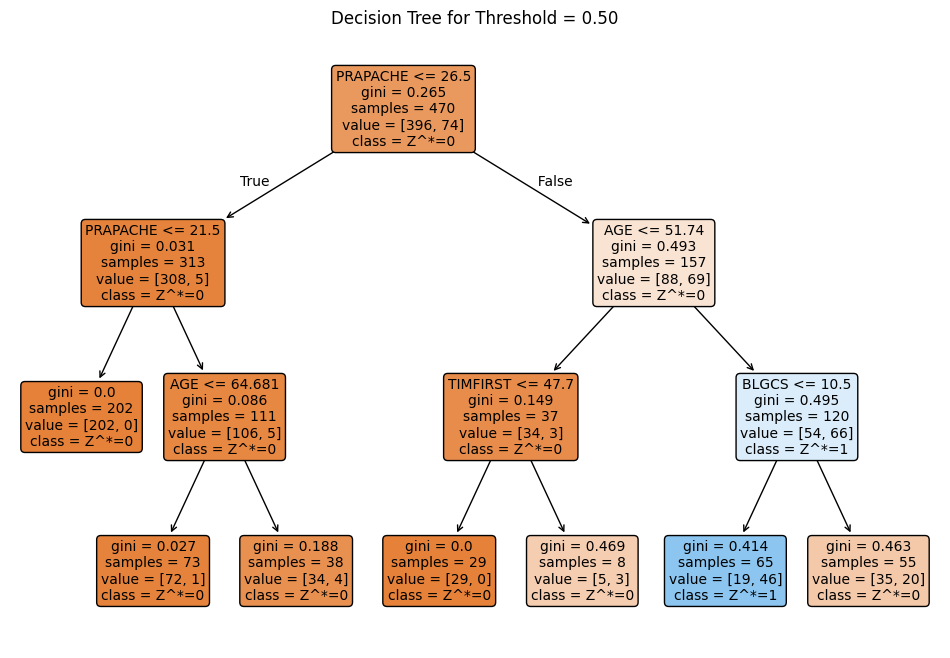

+---+--------------------------------------+---------------+-------+----------------------+--------------------+-----------------------+---------------------+------------+----------+
|   |               Subgroup               | Subgroup size | Class | Treatment event rate | Control event rate | Treatment sample size | Control sample size | RR (resub) | RR (snd) |
+---+--------------------------------------+---------------+-------+----------------------+--------------------+-----------------------+---------------------+------------+----------+
| 0 | BLIL6 > 44658.16 & BLIL6 <= 46598.54 |       1       |   1   |         nan          |        0.0         |           0           |          0          |    nan     |   nan    |
+---+--------------------------------------+---------------+-------+----------------------+--------------------+-----------------------+---------------------+------------+----------+


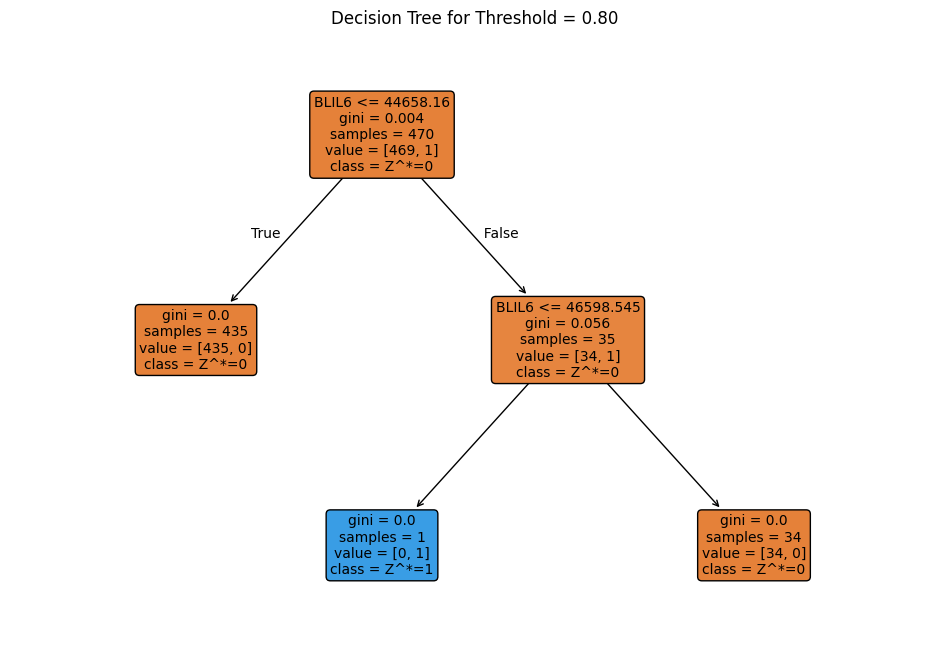

+---+----------------------------------------------------+---------------+-------+----------------------+---------------------+-----------------------+---------------------+--------------------+--------------------+
|   |                      Subgroup                      | Subgroup size | Class | Treatment event rate | Control event rate  | Treatment sample size | Control sample size |     RR (resub)     |      RR (snd)      |
+---+----------------------------------------------------+---------------+-------+----------------------+---------------------+-----------------------+---------------------+--------------------+--------------------+
| 0 |  PRAPACHE <= 26.50 & AGE > 57.98 & BLLBILI > 4.44  |      13       |   1   |  0.8163265306122449  | 0.25925925925925924 |          98           |          0          | 3.1486880466472305 | 0.7520408163265306 |
| 1 |  PRAPACHE > 26.50 & AGE <= 51.74 & BLLBILI > 1.75  |      19       |   1   |  0.8163265306122449  | 0.25925925925925924 |         

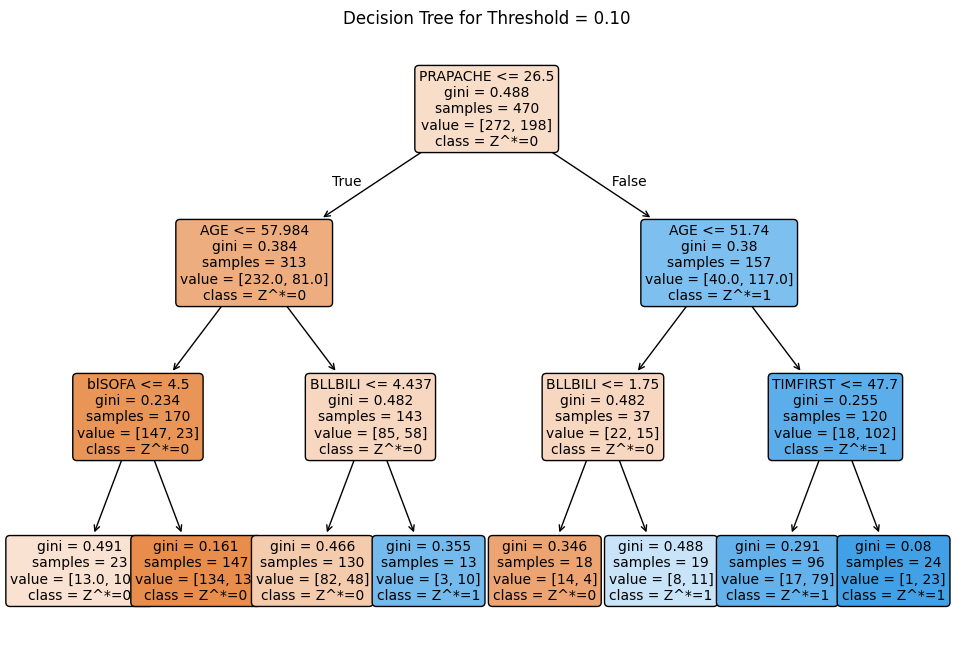


Tree 1: Threshold = 0.50
                                          Subgroup  Subgroup size  Class  \
0  PRAPACHE > 26.50 & AGE > 51.74 & BLGCS <= 10.50             65      1   

   Treatment event rate  Control event rate  Treatment sample size  \
0              0.909091            0.333333                     44   

   Control sample size  RR (resub)  RR (snd)  
0                    0    2.727273  0.863636  

Tree 2: Threshold = 0.80
                               Subgroup  Subgroup size  Class  \
0  BLIL6 > 44658.16 & BLIL6 <= 46598.54              1      1   

   Treatment event rate  Control event rate  Treatment sample size  \
0                   NaN                 0.0                      0   

   Control sample size  RR (resub)  RR (snd)  
0                    0         NaN       NaN  

Tree 3: Threshold = 0.10
                                            Subgroup  Subgroup size  Class  \
0   PRAPACHE <= 26.50 & AGE > 57.98 & BLLBILI > 4.44             13      1   
1   PRAPACHE

In [ ]:
# Compute Z_i
Z = P1 - P0

# Define thresholds as a vector
thresholds = [0.5, 0.8, 0.1]

# Initialize a list to store trees and subgroups
trees_and_subgroups = []

# Create a classification tree for each threshold
for c in thresholds:
    # Define Z^* for the current threshold
    Z_star = (Z > c).astype(int)
    
    # Initialize and train the decision tree classifier
    tree_classifier = DecisionTreeClassifier(max_depth=3, random_state=123)
    tree_classifier.fit(X, Z_star)
    
    # Extract subgroups using the vt_subgroups function
    subgroups_df = vt_subgroups(
        tree_classifier,  # Pass the tree_classifier as a positional argument
        X.columns,         # Pass the feature names as a positional argument
        X,                # Pass X as a positional argument
        Y,                # Pass Y as a positional argument
        T,                # Pass T as a positional argument
        only_leaf=True,   # Only show terminal nodes
        only_fav=True,    # Only show nodes with Z^* = 1
        tables=True,      # Print the table
        verbose=False,    # No verbose output
        compete=True      # No competitor rules
    )
    
    # Store the tree and subgroups
    trees_and_subgroups.append({
        "threshold": c,
        "tree": tree_classifier,
        "subgroups": subgroups_df
    })

    # Plot the decision tree
    plt.figure(figsize=(12, 8))
    plot_tree(
        tree_classifier,
        filled=True,  # Fill nodes with colors
        feature_names=X.columns,  # Use feature names for splitting rules
        class_names=["Z^*=0", "Z^*=1"],  # Class labels
        rounded=True,  # Rounded node corners
        fontsize=10  # Font size for labels
    )
    plt.title(f"Decision Tree for Threshold = {c:.2f}")
    plt.show()

# Display results for each tree
for i, tree_data in enumerate(trees_and_subgroups):
    c = tree_data["threshold"]
    subgroups_df = tree_data["subgroups"]
    
    print(f"\nTree {i + 1}: Threshold = {c:.2f}")
    print(subgroups_df)

